In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import io
from PIL import Image
from matplotlib import animation
from bokeh.palettes import d3

In [3]:
df = pd.read_csv('../data/minimus-20221209-1945.csv', parse_dates=['datetime'])

Some junk detections lie outside of the experimental chamber. We can roughly crop these off.

In [4]:
df = df[df['z_cm'] > 450]

Let's just focus on the long tracks, longer than 10 seconds long.

In [5]:
long_tracks = []
for group_name, group_df in df.groupby("id"):

    # calculate the length in time of each track
    duration = group_df['datetime'].iloc[-1] - group_df['datetime'].iloc[0]
    duration = duration.total_seconds()

    if duration > 10:
        long_tracks.append(group_name)
        print(f'{group_name}: {duration} seconds')

01GKW6VJ1FY1TRRY7TW69E2SNC: 17.610078 seconds
01GKW6WKH16XNDE8HCSZXQPRR1: 13.58006 seconds
01GKW772JB5XA0PCJT61KSCPBX: 36.600161 seconds
01GKW7BS03CQPE990Y3VCX732M: 14.470064 seconds
01GKW7CCKKV6ETF79D8ZHZX62W: 10.830047 seconds
01GKW7D6TNAF3N1C4SEVVQ3WJ5: 11.52005 seconds
01GKW7DZ12PVN1HNN3JY328RG7: 15.030066 seconds
01GKW7FXY6WDN6XFXRAA53D2K0: 11.820052 seconds
01GKW7G0C0JNHH92TCTFF36KRJ: 10.710047 seconds
01GKW7GSY4K7AJD8MBWK19DZ9T: 18.530082 seconds
01GKW7HC7E6EY3V7NQDMNSWBQE: 14.760065 seconds
01GKW7JWZ440T8KJFEGSQ3APW8: 10.660047 seconds


[Matplotlib 3D view angles](https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html) use a view-direction convention that's different than our data.

| mpl | data |
|-----|------|
| x   | z    |
| y   | x    |
| z   | y    |

Let's true plotting these tracks into time.
1. Subset by the track(s) we want to plot
2. Send the tracks and the times into the function (we can't subset yet, because we want a very consistent timeline)
3. In the function subset the dataset and plot, but the time listed should be

In [6]:
def plot_tail(
    ax, _group_df, _time_end, color, length=1.0, steps=10,
    min_linewidth = 2.0, max_linewidth = 5.0,
    min_alpha = 0.3, max_alpha = 1.0
    ):
    """Create a fading tail after the current time.

    Args:
        ax (plt.Axes): the axis to be modified
        _group_df (pd.DataFrame): dataframe with 'x_cm', 'y_cm', 'z_cm', and a DatetimeIndex.
        _time_end (pd.Timestamp): the timestamp representing the current time of frame being created
        color (str): color of the tail
        length (float, optional): length of the tail in seconds. Defaults to 1.0.
        steps (int, optional): number of steps across which to spread the tail. Defaults to 10.

    Returns:
        plt.Axes: returns the axes with edits in place.
    """
    
    alpha_increment = (max_alpha - min_alpha) / steps

    linewidths = np.linspace(min_linewidth, max_linewidth, steps+1)
    time_steps = np.linspace(0, length, steps+1)

    for i in range(len(time_steps)):
        _stime = _time_end - pd.Timedelta(f'{time_steps[i]}s')
        ax.plot(_group_df['z_cm'].loc[_stime:_time_end], _group_df['x_cm'].loc[_stime:_time_end],
            _group_df['y_cm'].loc[_stime:_time_end], alpha=alpha_increment, linewidth=linewidths[i], color=color)
    return ax

def plot_endpoint(
    ax, _location, _time_end, color, length=1.0,
    markersize=12, markeredgewidth=2, markeredgecolor='white',
    min_alpha = 0.3, max_alpha = 1.0
):
    """Plot a single point that fades as it's time gets further ahead of time_end.

    Args:
        ax (plt.Axes): the axis to be modified
        _location (pd.Series): with 'x_cm', 'y_cm', 'z_cm', a name attribute that is pd.Timestamp.
        _time_end (pd.Timestamp): the timestamp representing the current time of frame being created
        color (str): color of the point
        length (float, optional): length of the ease out in seconds. Defaults to 1.0.

    Returns:
        _type_: _description_
    """

    ease_alpha = max_alpha - min_alpha

    # how many seconds are we from the _time_end?
    seconds_diff = (_time_end - _location.name).total_seconds()

    if seconds_diff <= 0:
        last_point_alpha = max_alpha
    elif  length > seconds_diff > 0:
        last_point_alpha = 1 - (seconds_diff / length * ease_alpha)
    else:
        last_point_alpha = min_alpha

    ax.plot(_location['z_cm'], _location['x_cm'], _location['y_cm'],
        marker='o', markersize=markersize, markerfacecolor=color, alpha=last_point_alpha,
        markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth,
        linestyle='None'
    )

    return ax

def plot_frame(
    tracks,
    time_start=None,
    time_end=None,
    elev=10,
    azim=190,
    roll=0,
    title='',
    legend=False,
    data_limits=False
):
    """
    A frame of our animation, starting at the beginning of the data and going to the
    time provided.
    """

    elapsed_time = (time_end - time_start).total_seconds()
    elapsed_time_label = f'{elapsed_time:.02f}'
    colors = iter(d3['Category20'][len(tracks.groupby('id'))])

    fig = plt.figure(dpi=72, figsize = (20, 11.25))

    ax = fig.add_axes([0,0,0.5,1], projection = '3d')
    # plot each group individually based on their id
    for group_name, group_df in tracks.groupby('id'):
        color = next(colors)
        group_df = group_df.loc[time_start:time_end]

        # whole track, tail, endpoint
        ax.plot(group_df['z_cm'], group_df['x_cm'], group_df['y_cm'], label=group_name, alpha=0.3, color=color)
        ax = plot_tail(ax, group_df, time_end, color, length=1.0, steps=10)
        ax = plot_endpoint(ax, group_df.iloc[-1], time_end, color, length=1)
    
    ax.view_init(elev=elev, azim=azim, roll=roll)
    ax.set_xlabel('z_cm')
    ax.set_ylabel('x_cm')
    ax.set_zlabel('y_cm')

    if legend:
        ax.legend(loc='upper left', ncols=3, columnspacing=1, frameon=False, fontsize=8,
        borderpad=1.0)

    ax.set_aspect('equal', adjustable='box')

    if not data_limits:
        ax.set_xlim(450, 1050)
        ax.set_ylim(-160, 160)
        ax.set_zlim(-160, 160)
    
    ax.text2D(0.05, 1.02, title,
        fontsize=24, ha='left', va='bottom', linespacing=1.4, transform=ax.transAxes)
    
    ax.text2D(0.95, 1.02, f'{elapsed_time_label} seconds',
        fontsize=24, ha='right', va='bottom', linespacing=1.4, transform=ax.transAxes)


    # save and pass back
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', format='PNG')
    #fig.savefig(buf, format='PNG')
    plt.close(fig)
    
    return Image.open(buf)

In [7]:
def normalize_start_time(
    _df: pd.DataFrame,
    start_time: pd.Timestamp
) -> pd.DataFrame:
    """Normalize the index of the given DataFrame to the start_time"""
    result = _df.copy()
    result.index = result.index - (result.index[0] - start_time)
    return result

def normalize_all_starts(
    _df:pd.DataFrame,
    start_time: pd.Timestamp
) -> pd.DataFrame:
    """Normalize the start times of all tracks based on their id"""

    results = []
    for group_name, group_df in _df.groupby('id'):
        group_df = normalize_start_time(group_df, start_time)
        results.append(group_df)
    results = pd.concat(results)
    return results

In [8]:
# bring in a list of images and write to an output file

def make_movie_mp4(image_array, output_file, fps_count=24*4):
    dpi = 72.0
    width, height = image_array[0].size[0], image_array[0].size[1]
    
    # make frames with each figure being the exact dimensions of our plots
    fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im)
    
    mywriter = animation.FFMpegWriter(fps=fps_count, bitrate=-1)
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=(1./fps_count * 1000.))
    
    anim.save(output_file, mywriter)
    
    return anim

In [9]:
# sub = df[df['id'] == long_tracks[9]].copy()
sub = df[df['id'].isin(long_tracks)].copy()
sub.index = sub['datetime']
sub = normalize_all_starts(sub, sub.index[0])

In [10]:
timeline = pd.date_range(start=sub.index.min(), end=sub.index.max(), freq='10L')
camera_elev = np.linspace(10, 20, num=len(timeline))
camera_azim = np.linspace(190, 200, num=len(timeline))

In [11]:
i=500
img = plot_frame(sub, time_start=timeline[0], time_end=timeline[i], title='Minimus experiment 2022-12-09')

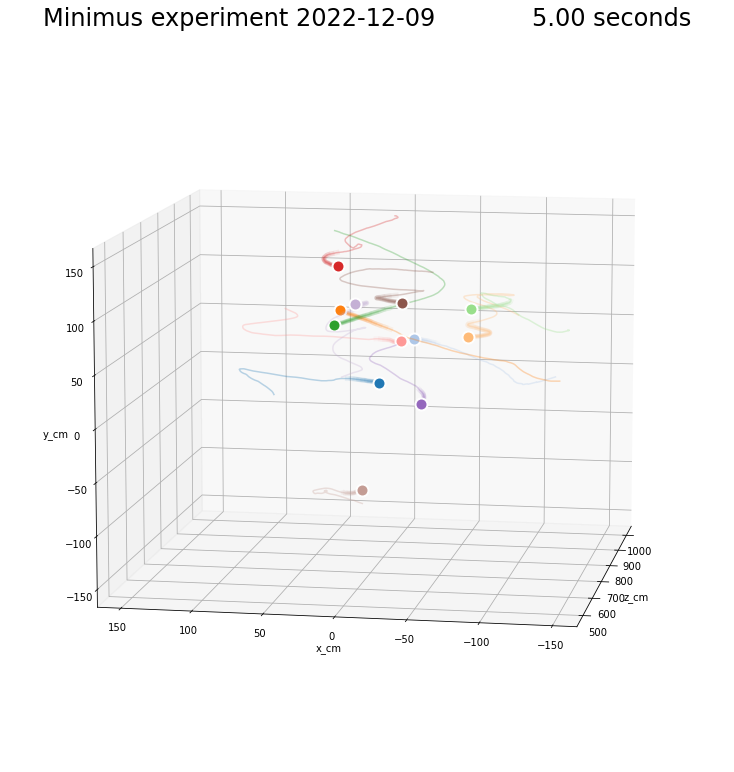

In [12]:
img

In [ ]:
%%time
results = []
for i in trange(len(timeline)):
    result = plot_frame(sub, time_start=timeline[0], time_end=timeline[i], title='Minimus experiment 2022-12-09')
    results.append(result)

In [14]:
# import pickle
# pickle.dump(results, open('../outputs/temp.pickle', 'wb'))

# import pickle
# results = pickle.load(open('../outputs/temp.pickle', 'rb'))

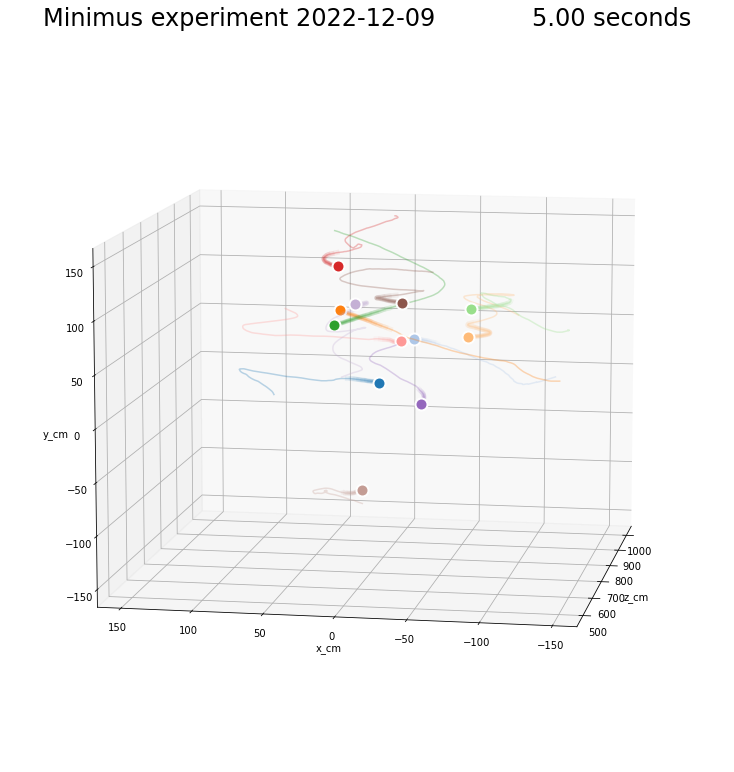

In [15]:
results[500]

In [17]:
anim = make_movie_mp4(results, f'../outputs/Minimusexperiment2022-12-09.mp4')

<Figure size 734x772 with 0 Axes>

In [18]:
%%time
results = []
for i in trange(len(timeline)):
    result = plot_frame(sub, time_start=timeline[0], time_end=timeline[i], title='Minimus experiment 2022-12-09',
        elev=90, azim=180)
    results.append(result)

anim = make_movie_mp4(results, f'../outputs/Minimus experiment 2022-12-09 top.mp4')

  0%|          | 0/3661 [00:00<?, ?it/s]

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x210b772e0>
Traceback (most recent call last):
  File "/Users/koeppen/opt/miniconda3/envs/mosquito-tracking/lib/python3.11/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))

KeyboardInterrupt: 


This runs me out of memory, which is a bummer. I'd be curious about the research workspace....

In [ ]:
# from dask.distributed import Client, LocalCluster
# from distributed import progress
# import multiprocessing as mp

# with LocalCluster(n_workers=int(0.9 * mp.cpu_count()),
#     processes=True,
#     threads_per_worker=1,
#     memory_limit='2GB'
# ) as cluster, Client(cluster) as client:

#     [future_track] = client.scatter([sub], broadcast=True)
#     futures = [client.submit(
#         plot_frame, future_track, time_start=timeline[0], time_end=timeline[i], title='Minimus experiment 2022-12-09',
#         ) for i in range(0, len(timeline))]

#     results = client.gather(futures, 'skip')